In [5]:
import os
import sys
import glob
import pprint

import IPython.display as display


import climatools.misc as climamisc

In [19]:
def fortran_files():
    rootdir = '/nuwa_cluster/home/jackyu/radiation/rrtmg/LW/rrtmg_lw_v4.85/column_model/src/'
    filetypes = ('.f90', '.f')
    fpaths = [os.path.join(rootdir, name) for name in os.listdir(rootdir) if name.endswith(filetypes)]
    return fpaths

In [4]:
#pprint.pprint(climamisc.Fortran_subroutine_relations_from_files(paths_fortran = fortran_files()))

## Reference MLS atmosphere

In RRTMG there is a reference mid-latitude summer atmosphere.  It has 59 altitudes.  These altitudes are usually enumerated using $j_p$.  $j_p = 1$ corresponds to the lowest altitude and $j_p = 59$ corresponds to the highest. 

For each altitude there is stored:

* $pref$: pressure
* $preflog$: log (natural) pressure 
* $tref$: temperature

$pref$ covers, approximately, the range 1050 milibar to 0.01 milibar.  The values are chosen such that $preflog[i] - proflog[i + 1] = 0.2$.  

Also stored for this reference atmosphere are gas concentrations:

* $chi\_mls[1, 1:59]$: h2o concentration 
* $chi\_mls[2, 1:59]$: co2 concentration
* $chi\_mls[3, 1:59]$: o3 concentration
* other gases


## Binary gas parameter

RRTMG uses the *binary gas parameter* to describe the overlap of a pair of gases.  In the pair, one gas is chosen to be the central one, and the concentration of the other is 'mixed' into that of the central one.  For example, say in some atmosphere layer the concentration of h2o and co2 are $colh2o$ and $colco2$, respectively, then, by choosing h2o as the central gas of the pair, the binary gas parameter $\eta$ with respect to a mid-latitude summer atmosphere is:

\begin{equation}
\eta = colh2o + \frac{colh2o_{mls}}{colco2_{mls}} colco2
\end{equation}

where $colh2o_{mls}$ and $colco2_{mls}$ are the concentrations of h2o and co2 in the mid-latitude summer atmosphere.  Notice that $\eta$ is defined with respect to some reference atmosphere; in this case, the mid-latitude summer atmosphere.  The second term in the RHS of the above equation is the concentration h2o would have in a mls atmosphere if the concentration of co2 were $colco2$.

## Gas absorption coefficient tables

Pre-computed gas absorption coefficients are stored in arrays, or tables,  ready to be interpolated during a calculation.  The stored values cover a space over the dimensions *fractional binary gas concentration*, *pressure*, *temperature*  and *k-interval*.  *Binary gas* here implies that the stored values are for a pair of overlapping gases. So for each pair of overlapping gases taken into account in RRTMG, there is a corresponding table of pre-computed absorption coefficients.

For example, if $ka$ is the table for binary major gases h2o and co2, then $ka$ is a rank-4 array, and $ka[i_s, i_t, i_p, i_g]$ is a stored absorption coefficient value at:

* the $i_p$'th altitude in the reference mls atmosphere, hence at pressure $pref[i_p]$
* temperature $15 (i_t -3) + tref[i_p]$. Since $i_t = 1, 2, 3, 4, 5$, this temperature is restricted to within 60 K of the altitude's reference temperature, $tref[i_p]$
* h2o-to-co2 ratio ($i_s = 1, 2, ..., 9$)

\begin{equation}
\frac{colh2o}{colco2} = \frac{1}{\left(\frac{8}{i_s-1}\right) - 1} 
\frac{chi\_mls[1, i_p]}{chi\_mls[2, i_p]}
\end{equation}

* the $i_g$'th g-point




## 1-D look-up index

Given indices $i_s$, $i_t$, $i_p$ and $i_g$, one can look up an absorption coefficient value in a table like $ka$.  However, in practice, the first three dimensions are flattened into a single dimension in RRTMG before a value is looked up:

```
equivalence (ka(1,1,1,1),absa(1,1)),(kb(1,1,13,1),absb(1,1))
```

Here, the first three dimensions of $ka$ are collapsed into one, and the resulting 2-d table is called $absa$.  When using $i_s$, $i_t$ and $i_p$ to look up a value in $absa$, the index $ind$ is first computed:

\begin{equation}
ind = 9 \cdot 5 \cdot (i_p - 1) + 9 \cdot (i_t - 1) + i_s
\end{equation}

$9$ is the length of the $i_s$ dimension; $5$ is the length of $i_t$ dimension.  Since $i_p$ is the innermost rank of the three, the number of elements in the table before it is the product of the lengths of those outer dimensions.  Similarly for the $i_t$ term.  Since $i_s$ is the outermost dimension, it is simply added to the total.  $ind$ can then be used to look up a value in $absa$:

\begin{equation}
ka[i_s, i_t, i_p, i_g] = absa[ind, i_g]
\end{equation}

## Finding the nearest $i_s$, $i_t$ and $i_p$ during interpolation

Given some pressure $P$, temperature $T$, h2o concentration $colh2o$, co2 concentration $colco2$, and $i_{g}$, there is a $(i_s, i_t, i_p, i_g)$ that is nearest to it.  Knowing this is needed to find the interpolated absorption coefficient.  Here it is described how.  

The pressure $P$ is first located on the altitude scale of the reference mls atmosphere: 

\begin{equation}
x_p = (36 - 5 (\ln{P} + 0.04))
\end{equation}

The index of the altitude in the mls reference atmosphere closest to $P$ is defined to be:

\begin{equation}
j_p = \mathrm{int} (x_p)
\end{equation}

At this altitude, the temperature, h2o and co2 concentration in the  reference mls atmosphere are $tref[j_p]$, $chi\_mls[1, j_p]$ and $chi\_mls[2, j_p]$, respectively.

Using the temperature scale along the temperature dimension of the absorption coefficient table $ka$, it is found how far $T$ is above, or below, $tref[j_p]$:

\begin{equation}
x_t = 3 + \frac{T - tref[j_p]}{15}
\end{equation}

Similarly, using the same scale as used in $ka$, it is found how the h2o-to-co2 ratio, $colh2o \: / \: colco2$, compares with that in the reference mls atmosphere:

\begin{equation}
x_s = 8 \frac{colh2o}{ colh2o + \frac{chi\_mls[1, j_p]}{chi\_mls[2, j_p]} colco2 }
\end{equation}

Using these, the nearest $i_t$ and $i_s$ are defined to be:
\begin{align}
j_t & = & \mathrm{int}(x_t) \\
j_s & = & \mathrm{int}(x_s) + 1
\end{align}

For interpolation, the inverval between the rounded values and the actual values are important, and for $x_s$, $x_t$ and $x_p$, we take the following intervals:

\begin{align}
f_s & = & x_s - (j_s - 1) \\
f_p & = & x_p - j_p \\
f_t & = & x_t - j_t 
\end{align}

The table indices $j_s$, $j_t$ and $j_p$ and the intervals $f_s$, $f_t$ and $f_p$ are depicted in the diagram below.

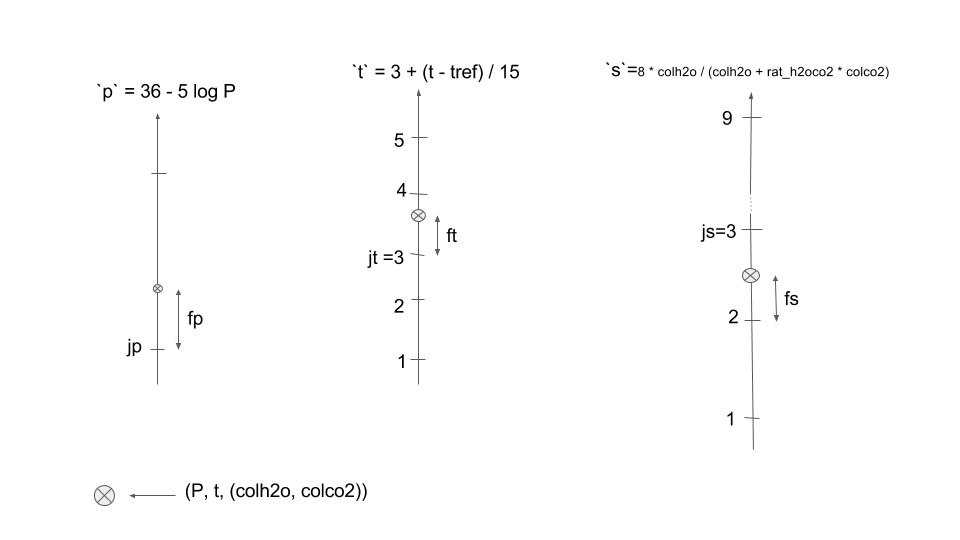

In [2]:
display.Image('diagram1_-_rrtmg_lw_taumol.png')

## Lower-altitude and higher-altitude contributions

On the altitude scale, $j_p$ is below $x_p$.  $j_{p1} = j_p + 1$ is above $x_p$.  To obtain the interpolated absorption coefficient at $x_p$, table (absorption coefficient) values at $j_p$ and $j_{p1}$ both need to be looked up.  

We already have the indices and intervals associated with $j_p$, namely $j_s$, $j_t$, $f_s$ and $f_t$.  For $j_{p1}$, the indices and intervals are calculated the same way, and we denote these by: $j_{s1}$, $j_{t1}$, $f_{s1}$ and $f_{t1}$.  These are shown in the diagram below.


So now in total, we have:

* lower-altitude ----- $j_p$, $j_s$, $j_t$, $f_s$ and $f_t$  
* higher-altitude ----- $j_{p1}$, $j_{s1}$, $j_{t1}$, $f_{s1}$ and $f_{t1}$


$f_p$, or $1 - f_p$, weighs the lower and higher altitude contributions.

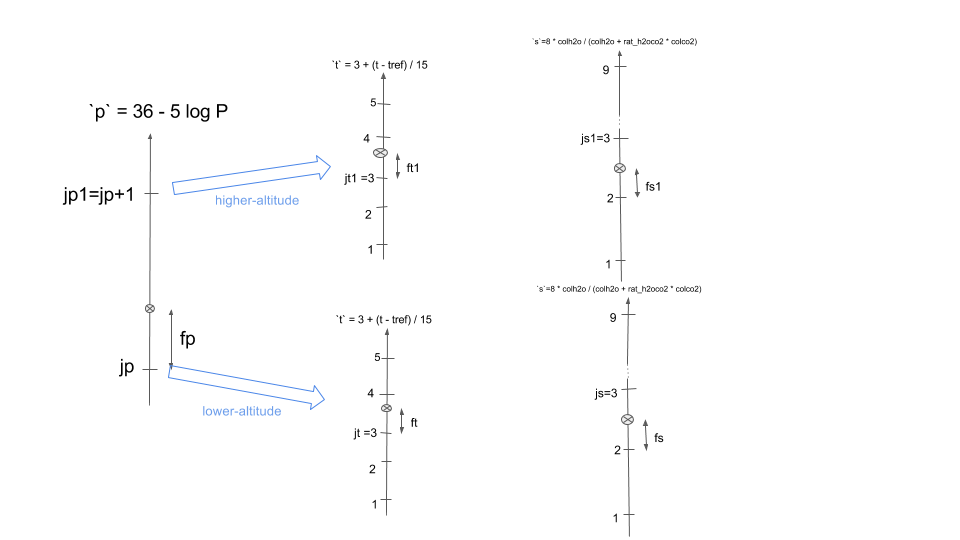

In [3]:
display.Image('diagram2_-_rrtmg_lw_taumol.png')

## Interpolated absorption coefficient

We now have all the terms needed to express the interpolated absorption coefficient, which we will simply show here without explaining the form comes from.  

The lower-altitude contribution is:

\begin{align}
k = & \; (1 - f_s) \cdot (1 - f_t) \cdot (1 - f_p) \cdot & absa[\: 9 (5 (j_p - 1) + (j_t - 1)) + j_s , i_g] \\
+ & \;  f_s \cdot (1 - f_t) \cdot (1 - f_p) \cdot & absa[\: 9 (5 (j_p - 1) + (j_t - 1)) + j_s + 1 , i_g] \\
+ & \;  (1 - f_s) \cdot f_t \cdot (1 - f_p) \cdot & absa[\: 9 (5 (j_p - 1) + (j_t + 1 - 1)) + j_s , i_g] \\
+ & \;  f_s \cdot f_t \cdot (1 - f_p) \cdot & absa[\: 9 (5 (j_p - 1) + (j_t + 1 - 1)) + j_s + 1, i_g] \\
= & \; fac_{000} \cdot & absa[ind_0, ig] \\
+ & \; fac_{100} \cdot & absa[ind_0 + 1, i_g] \\
+ & \; fac_{010} \cdot & absa[ind_0 + 9, i_g] \\
+ & \; fac_{110} \cdot & absa[ind_0 + 10, i_g] \\
\end{align}
, where
\begin{equation}
ind_0 = 9 \cdot 5 \cdot (j_p - 1) + 9 \cdot (j_t - 1) + j_s \quad.
\end{equation}

It can be seen that a 'lower' index always matches a 'higher' interval, while a 'higher' index always matches a 'lower' interval.  For example, take the first term in the RHS, index looked up in $absa$ points to the point $(j_s, j_t, j_p)$.  $j_s$ is the 'higher' index (since $j_s > x_s$), so there is a $(1 - j_s)$, which is the 'lower' interval (see above diagram).  $j_t$ is the 'lower' index, and there is a 'higher' interval, $(1 - f_t)$.  Since $k$ is associated with $j_p$, the lower altitude, there is a higher altitude interval, $(1 - f_p)$.


Similarly, for the higher-altitude:

\begin{align}
k_1 = & \; (1 - f_{s1}) \cdot (1 - f_{t1}) \cdot f_{p} \cdot & absa[\: 9 (5 (j_{p1} - 1) + (j_{t1} - 1)) + j_{s1} , i_g] \\
+ & \;  f_{s1} \cdot (1 - f_{t1}) \cdot f_p \cdot & absa[\: 9 (5 (j_{p1} - 1) + (j_{t1} - 1)) + j_{s1} + 1 , i_g] \\
+ & \;  (1 - f_{s1}) \cdot f_{t1} \cdot f_p \cdot & absa[\: 9 (5 (j_{p1} - 1) + (j_{t1} + 1 - 1)) + j_{s1} , i_g] \\
+ & \;  f_{s1} \cdot f_{t1} \cdot f_p \cdot & absa[\: 9 (5 (j_{p1} - 1) + (j_{t1} + 1 - 1)) + j_{s1} + 1, i_g]\\
= & \; fac_{001} \cdot & absa[ind_1, ig] \\
+ & \; fac_{101} \cdot & absa[ind_1 + 1, i_g] \\
+ & \; fac_{011} \cdot & absa[ind_1 + 9, i_g] \\
+ & \; fac_{111} \cdot & absa[ind_1 + 10, i_g] \\
\end{align}
, where
\begin{equation}
ind_1 = 9 \cdot 5 \cdot (j_{p1} - 1) + 9 \cdot (j_{t1} - 1) + j_{s1} \quad.
\end{equation}

## Optical depth

By multiplying the *binary gas parameter* with the interpolated coefficients, we obtain the optical depth:

\begin{align}
\tau & = &  \left( colh2o + \frac{chi\_mls[1, j_p]}{chi\_mls[2, j_p]} colco2 \right) \cdot k \\
\tau_1 & = & \left( colh2o + \frac{chi\_mls[1, j_{p1}]}{chi\_mls[2, j_{p1}]} colco2 \right) \cdot k_1
\end{align}

If $P$, $T$, $colh2o$ and $colco2$ are the pressure, temperature and h2o and co2 concentration of some input atmosphere layer, then $\tau + \tau_1$ is the optical depth due to h2o and co2 in this layer.